# Scaling CMA-MAE on the Sphere Benchmark

_This tutorial is part of the series of pyribs tutorials! See [here](https://docs.pyribs.org/en/stable/tutorials.html) for the list of all tutorials and the order in which they should be read._

One challenge in applying CMA-MAE is its quadratic time complexity. Internally, CMA-MAE relies on CMA-ES, which has $\Theta(n^2)$ time and space complexity due to operations on an $n \times n$ covariance matrix. Thus, CMA-ES and hence CMA-MAE can be computationally intractable when a problem involves millions or even just thousands of parameters. To address this issue, [Tjanaka 2023](https://scalingcmamae.github.io) proposes to replace CMA-ES with more efficient evolution strategies (ESs), resulting in several variants of CMA-MAE. The CMA-MAE variants proposed in the paper and supported in pyribs are as follows:

- LM-MA-MAE: Replaces CMA-ES with [Limited Memory Matrix Adaptation ES (LM-MA-ES)](https://ieeexplore.ieee.org/document/8410043), which has $\Theta(kn)$ runtime.
- sep-CMA-MAE: Replaces CMA-ES with [separable CMA-ES (sep-CMA-ES)](https://inria.hal.science/inria-00270901v1/document), which constrains the covariance matrix to be diagonal and has $\Theta(n)$ runtime.
- OpenAI-MAE: Replaces CMA-ES with [OpenAI-ES](https://arxiv.org/abs/1703.03864), which performs search by sampling from an isotropic Gaussian and has $\Theta(n)$ runtime.

This tutorial shows how these different variants of CMA-MAE can be accessed by changing the `es` parameter in the [`EvolutionStrategyEmitter`](https://docs.pyribs.org/en/stable/api/ribs.emitters.EvolutionStrategyEmitter.html).

_Note: This tutorial is based on the [CMA-MAE tutorial](https://docs.pyribs.org/en/stable/tutorials/cma_mae.html). As such, we skim over details like how to set up the archives. For more details on these steps, please refer to that tutorial._

## Setup

In [ ]:
%pip install ribs[visualize] tqdm

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange

## The Sphere Linear Projection Benchmark

In this tutorial, we use a 1000-dimensional version of the sphere benchmark. At this dimensionality, CMA-MAE becomes extremely slow due to its quadratic complexity.

In [3]:
def sphere(solutions: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Sphere function evaluation and measures for a batch of solutions.

    Args:
        solutions: (batch_size, dim) batch of solutions.

    Returns:
        objectives: (batch_size,) batch of objectives.
        measures: (batch_size, 2) batch of measures.
    """
    dim = solutions.shape[1]

    # Shift the Sphere function so that the optimal value is at x_i = 2.048.
    sphere_shift = 5.12 * 0.4

    # Normalize the objective to the range [0, 100] where 100 is optimal.
    best_obj = 0.0
    worst_obj = (-5.12 - sphere_shift) ** 2 * dim
    raw_obj = np.sum(np.square(solutions - sphere_shift), axis=1)
    objectives = (raw_obj - worst_obj) / (best_obj - worst_obj) * 100

    # Calculate measures.
    clipped = solutions.copy()
    clip_mask = (clipped < -5.12) | (clipped > 5.12)
    clipped[clip_mask] = 5.12 / clipped[clip_mask]
    measures = np.concatenate(
        (
            np.sum(clipped[:, : dim // 2], axis=1, keepdims=True),
            np.sum(clipped[:, dim // 2 :], axis=1, keepdims=True),
        ),
        axis=1,
    )

    return objectives, measures

## Archive Setup

Note this archive has higher resolution (250x250) than the one in the CMA-MAE tutorial (100x100). As described in Appendix K of the [CMA-MAE paper](https://arxiv.org/abs/2205.10752), this is necessary due to the high dimensionality of the domain.

In [4]:
from ribs.archives import GridArchive

max_bound = 1000 / 2 * 5.12

archive = GridArchive(
    solution_dim=1000,
    dims=(250, 250),
    ranges=[(-max_bound, max_bound), (-max_bound, max_bound)],
    learning_rate=0.01,
    threshold_min=0.0,
)

result_archive = GridArchive(
    solution_dim=1000,
    dims=(250, 250),
    ranges=[(-max_bound, max_bound), (-max_bound, max_bound)],
)

## Emitter Setup with the `es` Parameter

Exactly like in the regular CMA-MAE, scalable variants of CMA-MAE are built with the [`EvolutionStrategyEmitter`](https://docs.pyribs.org/en/stable/api/ribs.emitters.EvolutionStrategyEmitter.html). The key difference is the choice of ES, which is indicated with the `es` parameter. `es` has the following options:

- `lm_ma_es`: Indicates LM-MA-ES
- `sep_cma_es`: Indicates sep-CMA-ES
- `openai_es`: Indicates OpenAI-ES

Below, we first show how to use `sep_cma_es` by passing `es="sep_cma_es"`.

In [5]:
from ribs.emitters import EvolutionStrategyEmitter

emitters = [
    EvolutionStrategyEmitter(
        archive,
        x0=np.zeros(1000),
        sigma0=0.5,
        ranker="imp",
        es="sep_cma_es",
        selection_rule="mu",
        restart_rule="basic",
        batch_size=36,
    )
    for _ in range(15)
]

It is also possible to pass in `es` as a class, as the string options to `es` are simply translated to a corresponding ES class (the documentation for all ES classes is [here](https://docs.pyribs.org/en/stable/api/ribs.emitters.opt.html)). All ES classes are subclasses of [`EvolutionStrategyBase`](https://docs.pyribs.org/en/stable/api/ribs.emitters.opt.EvolutionStrategyBase.html).

In [6]:
from ribs.emitters.opt import SeparableCMAEvolutionStrategy

emitters_v2 = [
    EvolutionStrategyEmitter(
        archive,
        x0=np.zeros(1000),
        sigma0=0.5,
        ranker="imp",
        es=SeparableCMAEvolutionStrategy,
        selection_rule="mu",
        restart_rule="basic",
        batch_size=36,
    )
    for _ in range(15)
]

Some ESs also accept kwargs. For instance, in [LMMAEvolutionStrategy](https://docs.pyribs.org/en/stable/api/ribs.emitters.opt.LMMAEvolutionStrategy.html), the size of the approximation can be adjusted with the `n_vectors` parameter. kwargs can be passed to the ESs with the `es_kwargs` parameter in `EvolutionStrategyEmitter`, as shown below.

In [7]:
# Regular instantiation of EvolutionStrategyEmitter with `lm_ma_es`.
lm_ma_emitters = [
    EvolutionStrategyEmitter(
        archive,
        x0=np.zeros(1000),
        sigma0=0.5,
        ranker="imp",
        es="lm_ma_es",
        selection_rule="mu",
        restart_rule="basic",
        batch_size=36,
    )
    for _ in range(15)
]

# Instantiation of EvolutionStrategyEmitter with `lm_ma_es` and kwargs.
lm_ma_emitters_v2 = [
    EvolutionStrategyEmitter(
        archive,
        x0=np.zeros(1000),
        sigma0=0.5,
        ranker="imp",
        es="lm_ma_es",
        es_kwargs={"n_vectors": 20},
        selection_rule="mu",
        restart_rule="basic",
        batch_size=36,
    )
    for _ in range(15)
]

Finally, [`GradientArborescenceEmitter`](https://docs.pyribs.org/en/stable/api/ribs.emitters.GradientArborescenceEmitter.html) also has as `es` parameter. However, it is less common to use a scalable ES in `GradientArborescenceEmitter` since the ES only operates in objective-measure coefficient space, and that space usually has only a few dimensions.

## Scheduler Setup

Note that we only use the `emitters` created above with `es="sep_cma_es"`.

In [8]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters, result_archive)

## Running Scalable CMA-MAE

Finally, we run the scalable CMA-MAE variant created above on a 1000-dimensional sphere function.

In [9]:
total_itrs = 10_000

for itr in trange(1, total_itrs + 1, file=sys.stdout, desc="Iterations"):
    solutions = scheduler.ask()
    objectives, measures = sphere(solutions)
    scheduler.tell(objectives, measures)

    # Output progress every 500 iterations or on the final iteration.
    if itr % 500 == 0 or itr == total_itrs:
        tqdm.write(
            f"Iteration {itr:5d} | "
            f"Archive Coverage: {result_archive.stats.coverage * 100:6.3f}%  "
            f"Normalized QD Score: {result_archive.stats.norm_qd_score:6.3f}"
        )

Iteration   500 | Archive Coverage:  7.370%  Normalized QD Score:  6.729                      
Iteration  1000 | Archive Coverage: 12.394%  Normalized QD Score: 10.728                      
Iteration  1500 | Archive Coverage: 15.531%  Normalized QD Score: 13.100                      
Iteration  2000 | Archive Coverage: 17.366%  Normalized QD Score: 14.356                      
Iteration  2500 | Archive Coverage: 19.149%  Normalized QD Score: 15.670                      
Iteration  3000 | Archive Coverage: 19.944%  Normalized QD Score: 16.195                      
Iteration  3500 | Archive Coverage: 21.136%  Normalized QD Score: 17.101                      
Iteration  4000 | Archive Coverage: 22.966%  Normalized QD Score: 18.396                      
Iteration  4500 | Archive Coverage: 24.563%  Normalized QD Score: 19.464                      
Iteration  5000 | Archive Coverage: 25.526%  Normalized QD Score: 20.108                      
Iteration  5500 | Archive Coverage: 26.158%  Norma

## Visualization

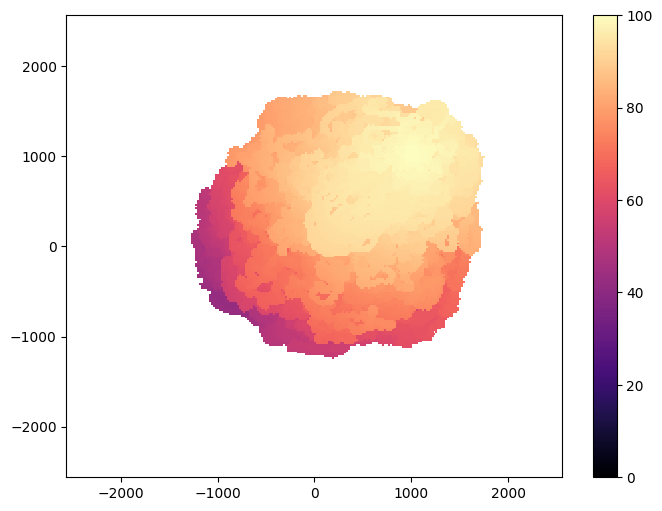

In [10]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(result_archive, vmin=0, vmax=100)

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_scalable_cma_mae,
  title   = {Scaling CMA-MAE on the Sphere Benchmark},
  author  = {Henry Chen and Bryon Tjanaka and Stefanos Nikolaidis},
  journal = {pyribs.org},
  year    = {2023},
  url     = {https://docs.pyribs.org/en/stable/tutorials/cma_mae.html}
}
```